# 2P vaso-constriction analysis

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tifffile import imread, imwrite
from scipy.io import loadmat
from scipy import stats

from logger import logger
from viewers import view_stack
from correctors import LinRegCorrector
from plotters import *
from postpro import *

### Input data and parameters

 2024/06/12 17:51:49: input data directory: /Users/tlemaire/Documents/data/hemo2p/m237_run7_set4
 2024/06/12 17:51:49: listing TIF files...
 2024/06/12 17:51:49: loading stack...
 2024/06/12 17:51:49: loaded 601-frames stack with shape 512x512
 2024/06/12 17:51:49: loaded 367 ROIs mask
 2024/06/12 17:51:50: fps: 1.00 Hz, spatial resolution: 1.29 µm/px


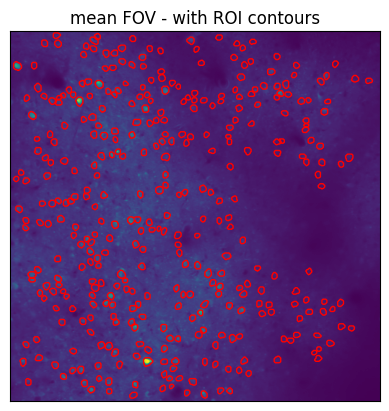

In [3]:
# Construct path to data directory
dataroot = '/Users/tlemaire/Documents/data/hemo2p'
run = 'm237_run7_set4'
datadir = os.path.join(dataroot, run)
logger.info(f'input data directory: {datadir}')

# Figures directory & dictionary
figsdir = os.path.join(dataroot, 'figs')
figs = {}

# Create stacks directory if it does not exist
stacksdir = os.path.join(datadir, 'stacks')
if not os.path.exists(stacksdir):
    os.makedirs(stacksdir)
    logger.info(f'created stacks directory: {stacksdir}')

# List all sorted TIF files in the data directory
logger.info('listing TIF files...')
tif_files = [f for f in os.listdir(datadir) if f.endswith('.ome.tif')]
tif_files.sort()

# Load TIFs and assemble stack
logger.info('loading stack...')
stackfpath = os.path.join(stacksdir, 'stack_original.tif')
if os.path.exists(stackfpath):        
    stack = imread(stackfpath)
else:
    stack = np.array([imread(os.path.join(datadir, file)) for file in tif_files])
    imwrite(stackfpath, stack)
nframes, nx, ny = stack.shape
logger.info(f'loaded {nframes}-frames stack with shape {nx}x{ny}')

# Load ROI mask
mask_fpath = os.path.join(datadir, 'masks', 'labelimg.mat')
masks = loadmat(mask_fpath)['labelimg']
nrois = masks.max()
ROIlabels = [f'ROI{i+1}' for i in range(nrois)]
logger.info(f'loaded {nrois} ROIs mask')

# Get ROI masks
ROImasks = {}
for i in range(nrois):
    ypix, xpix = np.where(masks == i + 1)
    df = pd.DataFrame({'xpix': xpix, 'ypix': ypix})
    df.index.name = 'pixel'
    ROImasks[f'ROI{i+1}'] = df
ROImasks = pd.concat(ROImasks, axis=0, names=['ROI'])
ROIcontours = get_ROI_contours(ROImasks, (ny, nx), color='r', lw=1)

# Plot stack projection FOV and ROI contours
figs['mean FOV with ROI contours'], ax = plt.subplots()
ax.imshow(
    stack.mean(axis=0), 
    cmap='viridis', 
)
ax.set_title('mean FOV - with ROI contours')
ax.set_xticks([])
ax.set_yticks([])
ax.add_collection(ROIcontours)

# Define recording parameters
fps = 1 / 0.77764  # frames per second
fps = 1
umperpx = 1.29  # µm/pixel
logger.info(f'fps: {fps:.2f} Hz, spatial resolution: {umperpx} µm/px')

# Define stimulus parameters
istims = np.arange(301, 404, 3)  # stimulus frames
istimbounds = (istims[0], istims[-1])  # indexes of frames bounding the stimulus interval 

# Identify frames indexes for pre, stim and post intervals
framesdict = {
    'pre': np.arange(istimbounds[0]),
    'stim': np.arange(istimbounds[0], istimbounds[1] + 1),
    'post': np.arange(istimbounds[1] + 1, nframes)
}

# Concatenate pre and post frames indexes into a 'nostim' interval
framesdict['nostim'] = np.concatenate([framesdict['pre'], framesdict['post']])

# Initialize stacks dictionary
stackdict = {'original': stack}

### Apply linear regression correctors

In [4]:
# For each correction type
robusts = [False, True]
intercepts = [True, False] 
for robust in robusts:
    for intercept in intercepts:
        # Inintialize corrector
        lrc = LinRegCorrector(robust=robust, intercept=intercept)
        # Construct full path to corrected stack file
        stackfile = f'stack_{lrc.code}.tif'
        stackfpath = os.path.join(stacksdir, stackfile)
        # Load stack if it exists
        if os.path.exists(stackfpath):
            logger.info(f'loading stack {lrc.code} from {stackfpath}...')
            stackdict[lrc.code] = imread(stackfpath)
        # Otherwise, apply correction and ave output to disk
        else:
            logger.info(f'correcting stack with {lrc.code}...')
            stackdict[lrc.code] = lrc.correct(stack)
            logger.info(f'saving corrected stack to {stackfpath}...')
            imwrite(stackfpath, stackdict[lrc.code])

 2024/06/12 17:51:51: loading stack linreg from /Users/tlemaire/Documents/data/hemo2p/m237_run7_set4/stacks/stack_linreg.tif...
 2024/06/12 17:51:51: loading stack linreg_nointercept from /Users/tlemaire/Documents/data/hemo2p/m237_run7_set4/stacks/stack_linreg_nointercept.tif...
 2024/06/12 17:51:51: loading stack linreg_robust from /Users/tlemaire/Documents/data/hemo2p/m237_run7_set4/stacks/stack_linreg_robust.tif...
 2024/06/12 17:51:51: loading stack linreg_robust_nointercept from /Users/tlemaire/Documents/data/hemo2p/m237_run7_set4/stacks/stack_linreg_robust_nointercept.tif...


### Compare original vs corrected stacks

In [5]:
view_stack(
    stackdict, 
    ilabels={'stim': istims}, 
    title=run,
)

 2024/06/12 17:51:52: initializing stack viewer
 2024/06/12 17:51:52: stack size: (601, 512, 512)
 2024/06/12 17:51:52: computing stack dynamic range across frames 0 - 600...


100%|██████████| 601/601 [00:00<00:00, 4005.89it/s]

 2024/06/12 17:51:52: stack dynamic range range: 0 - 9517
 2024/06/12 17:51:52: computing stack dynamic range across frames 0 - 600...



100%|██████████| 601/601 [00:00<00:00, 4328.75it/s]

 2024/06/12 17:51:52: stack dynamic range range: 1 - 11379
 2024/06/12 17:51:52: computing stack dynamic range across frames 0 - 600...



100%|██████████| 601/601 [00:00<00:00, 4446.75it/s]

 2024/06/12 17:51:52: stack dynamic range range: 0 - 11322
 2024/06/12 17:51:52: computing stack dynamic range across frames 0 - 600...



100%|██████████| 601/601 [00:00<00:00, 4041.50it/s]

 2024/06/12 17:51:52: stack dynamic range range: 1 - 11360
 2024/06/12 17:51:52: computing stack dynamic range across frames 0 - 600...



100%|██████████| 601/601 [00:00<00:00, 6247.73it/s]

 2024/06/12 17:51:52: stack dynamic range range: 0 - 11402
 2024/06/12 17:51:52: rendering stack view...


### Compute F and dFF traces for FOV-average and ROIs, across all stacks

In [6]:
# Extract fluorescence traces from stacks
F = extract_traces_df_from_stack(stackdict, masks=masks)

# Compute dF/F traces
dFF = compute_dff(F)

 2024/06/12 17:51:53: processing original stack...
 2024/06/12 17:51:53: computing FOV-mean trace over 601 frames
 2024/06/12 17:51:53: computing mean traces for 367 ROIs
 2024/06/12 17:51:54: processing linreg stack...
 2024/06/12 17:51:54: computing FOV-mean trace over 601 frames
 2024/06/12 17:51:54: computing mean traces for 367 ROIs
 2024/06/12 17:51:55: processing linreg_nointercept stack...
 2024/06/12 17:51:55: computing FOV-mean trace over 601 frames
 2024/06/12 17:51:55: computing mean traces for 367 ROIs
 2024/06/12 17:51:55: processing linreg_robust stack...
 2024/06/12 17:51:55: computing FOV-mean trace over 601 frames
 2024/06/12 17:51:56: computing mean traces for 367 ROIs
 2024/06/12 17:51:56: processing linreg_robust_nointercept stack...
 2024/06/12 17:51:56: computing FOV-mean trace over 601 frames
 2024/06/12 17:51:56: computing mean traces for 367 ROIs
 2024/06/12 17:51:57: computing dFF across ['kind']


### Compute ROI-specific baseline fluoresence levels

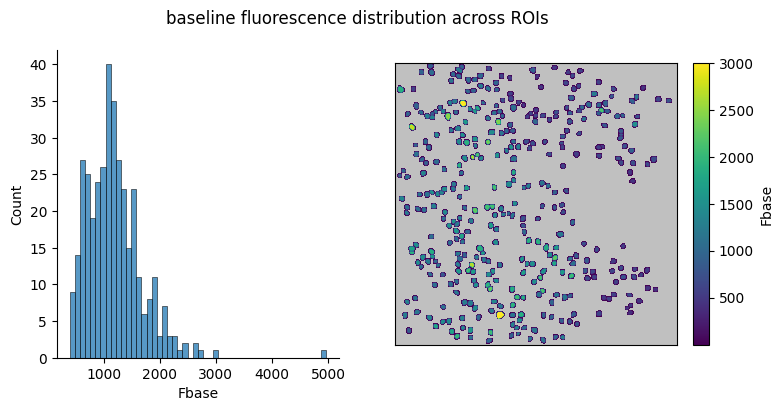

In [7]:
# Compute baseline fluorescence of each ROI from pre-stimulus interval of original stack
Fbase = F.loc[pd.IndexSlice['original', framesdict['pre']], :].quantile(0.1, axis=0).iloc[1:]
Fbase.index = pd.to_numeric(Fbase.index.str.strip('ROI')) - 1
Fbase.name = 'Fbase'
Fbase.index.name = 'ROI'

# Plot baseline fluorescence distribution and spatial distribution
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes[0]
sns.despine(ax=ax)
fig.suptitle('baseline fluorescence distribution across ROIs')
sns.histplot(Fbase, bins=50, ax=ax)
ax = axes[1]
basemask = masks.copy().astype(float)
for iROI, fb in Fbase.items():
    basemask[basemask == iROI + 1] = fb
cmap = plt.get_cmap('viridis')
cmap.set_under('silver')
sm = ax.imshow(basemask, cmap=cmap, vmin=1e-3, vmax=3000)
ax.set_xticks([])
ax.set_yticks([])
pos = ax.get_position()
cbar_ax = fig.add_axes([0.92, pos.y0, 0.02, pos.height])
fig.colorbar(sm, cax=cbar_ax, label='Fbase')
figs['Fbase dists'] = fig

### Compute ROI-specific change in dFF baseline between rest and stim periods, across all stacks 

 2024/06/12 17:52:06: ROI dFF change distributions:


,count,mean,std,min,25%,50%,75%,max
kind,,,,,,,,
linreg,367.0,0.020465,0.168015,-0.175474,-0.063968,-0.016774,0.076070,2.469634
linreg_nointercept,367.0,0.025688,0.183044,-0.206136,-0.061654,-0.011556,0.081760,2.697512
linreg_robust,367.0,0.024345,0.170117,-0.172716,-0.060037,-0.015873,0.077581,2.518737
linreg_robust_nointercept,367.0,0.025010,0.183568,-0.207463,-0.061678,-0.013626,0.081365,2.705207
original,367.0,0.298729,0.236625,-0.020919,0.181665,0.247708,0.368997,3.667473


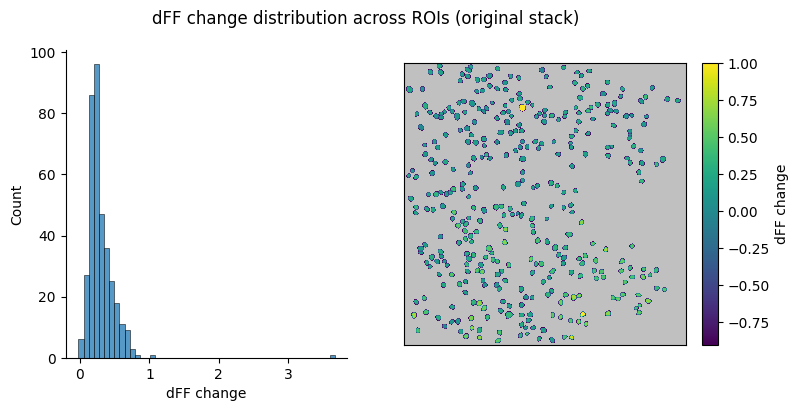

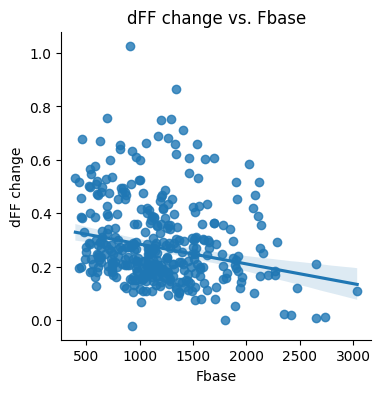

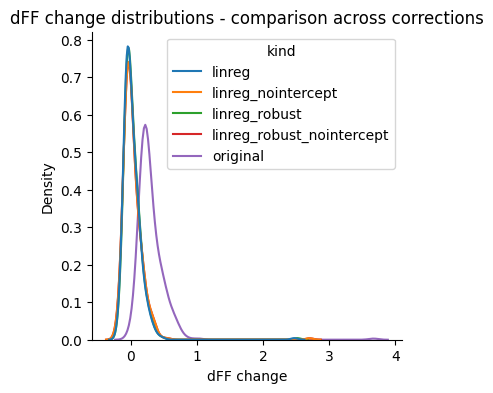

In [8]:
# Split traces into pre, stim and post intervals
dFF_split = {k: dFF.loc[pd.IndexSlice[:, v], :] for k, v in framesdict.items()}

# Compute baseline dFF values for each ROI and interval
dFF_refs = {
    k: v.groupby('kind').agg(lambda x: x.quantile(.1)) 
    for k, v in dFF_split.items()
}

# Compute dFF change as difference between stim and no-stim values
ROI_dFF_change = (dFF_refs['stim'] - dFF_refs['nostim']).iloc[:, 1:]
ROI_dFF_change.columns = pd.to_numeric(ROI_dFF_change.columns.str.strip('ROI')) - 1
ROI_dFF_change.columns.name = 'ROI'
ROI_dFF_change = ROI_dFF_change.stack().rename('dFF change')

# Plot dFF change distribution and spatial distribution from original stack
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
ax = axes[0]
sns.despine(ax=ax)
fig.suptitle('dFF change distribution across ROIs (original stack)')
sns.histplot(ROI_dFF_change.loc['original'], bins=50, ax=ax)
ax = axes[1]
dFFchange_mask = masks.copy().astype(float)
dFFchange_mask[dFFchange_mask == 0.] = -1
for iROI, dFFc in ROI_dFF_change.loc['original'].items():
    dFFchange_mask[dFFchange_mask == iROI + 1] = dFFc
cmap = plt.get_cmap('viridis')
cmap.set_under('silver')
sm = ax.imshow(dFFchange_mask, cmap=cmap, vmin=-.9, vmax=1)
ax.set_xticks([])
ax.set_yticks([])
pos = ax.get_position()
cbar_ax = fig.add_axes([0.92, pos.y0, 0.02, pos.height])
fig.colorbar(sm, cax=cbar_ax, label='dFF change')
figs['dFF change dists'] = fig

# Merge baseline fluorescence and dFF change dataframes, and remove outliers
df = pd.concat([Fbase, ROI_dFF_change.loc['original']], axis=1)
df = df[(np.abs(stats.zscore(df)) < 5).all(axis=1)]

# Plot dFF change as a function of baseline fluorescence
fig, ax = plt.subplots(figsize=(4, 4))
sns.despine(ax=ax)
ax.set_title('dFF change vs. Fbase')
sns.regplot(
    ax=ax,
    data=df,
    x='Fbase',
    y='dFF change',
    robust=True,
)
figs['dFF change vs Fbase'] = fig

# Plot distribution of dFF baseline change during stim, across corrections
fig, ax = plt.subplots(figsize=(4, 4))
ax.set_title('dFF change distributions - comparison across corrections')
sns.despine(ax=ax)
sns.kdeplot(
    ax=ax,
    data=ROI_dFF_change.reset_index(), 
    x='dFF change', 
    hue='kind',
    fill=False,
)
figs['dFF change dists comp'] = fig

# Sort ROIs by dFF change, for each stack
sorted_ROI_dFF_change = ROI_dFF_change.groupby('kind').apply(lambda x: x.sort_values().droplevel(0))
iROIs_by_change = {k: v.droplevel(0).index.values for k, v in sorted_ROI_dFF_change.groupby('kind')}

# Describe ROI dFF change distributions
logger.info('ROI dFF change distributions:')
ROI_dFF_change.groupby('kind').describe()

### Plot comparative traces for FOV average and a few random ROIs, across stacks

 2024/06/12 17:53:37: plotting dFF % traces for columns ['FOV']
 2024/06/12 17:53:37: plotting dFF % traces for columns ['FOV', 'ROI274', 'ROI294', 'ROI196']
 2024/06/12 17:53:37: plotting dFF % traces for columns ['FOV', 'ROI161', 'ROI239', 'ROI244']
 2024/06/12 17:53:37: plotting dFF % traces for columns ['FOV', 'ROI229', 'ROI125', 'ROI340']


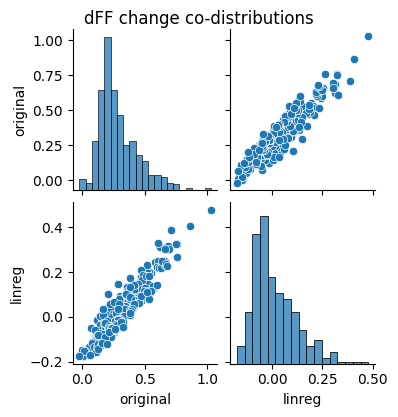

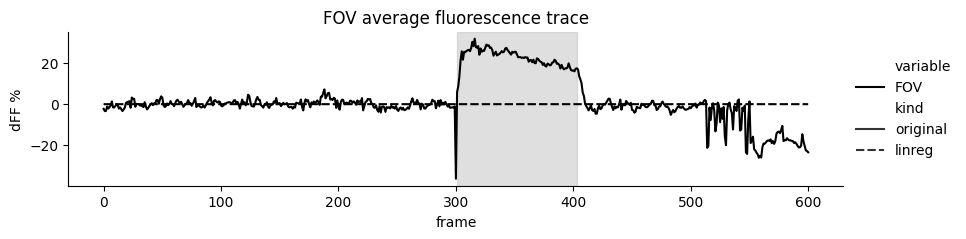

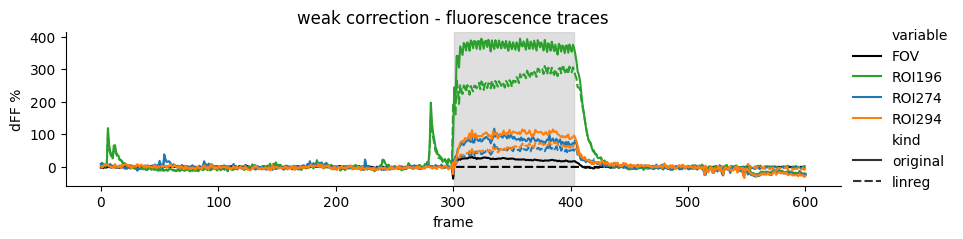

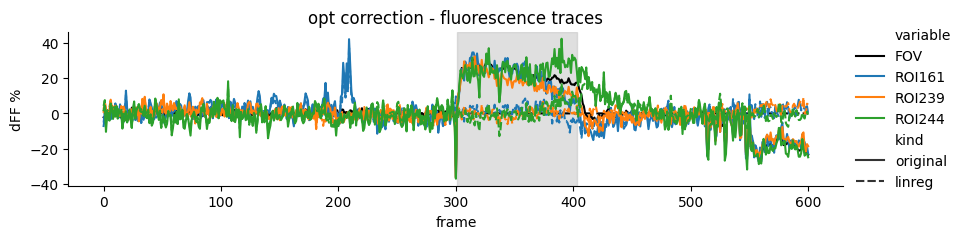

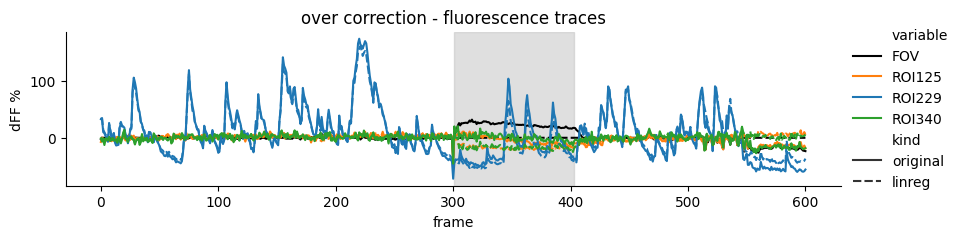

In [11]:
# Assemble traces dictionary
traces_dict = {
    # 'F': F, 
    'dFF %': dFF * 100
}

# Define reference correction key
refcorrkey = 'linreg'
traces_dict = {
    k: v[v.index.get_level_values('kind').isin(('original', refcorrkey))] 
    for k, v in traces_dict.items()
}

# Plot co-distributions of dFF change for original and reference corrected stacks
df = ROI_dFF_change.unstack().T[['original', refcorrkey]]
df = df[(np.abs(stats.zscore(df)) < 5).all(axis=1)]
g = sns.pairplot(df, height=2)
fig = g.figure
fig.suptitle('dFF change co-distributions', y=1.02)
figs['dFF change pairplot'] = fig

# Gather indexes of ROIs for which correction is too weak, optimal or too strong
nROIs_plt = 3
iROIs_dict = {
    'weak': sorted_ROI_dFF_change.loc[refcorrkey].tail(nROIs_plt).index.values,
    'opt': sorted_ROI_dFF_change.loc[refcorrkey].abs().sort_values().head(nROIs_plt).index.values,
    'over': sorted_ROI_dFF_change.loc[refcorrkey].head(nROIs_plt).index.values,
}

fig = plot_traces(
    traces_dict,
    istimbounds=istimbounds,
)
fig.axes[0].set_title(f'FOV average fluorescence trace');
figs[f'avg trace'] = fig

# Plot F and dFF traces
for k, iROIs in iROIs_dict.items():
    fig = plot_traces(
        traces_dict,
        iROIs=iROIs,
        istimbounds=istimbounds,
    )
    fig.axes[0].set_title(f'{k} correction - fluorescence traces');
    figs[f'{k} traces'] = fig

### Save figures

In [12]:
save_figs_book(figsdir, figs)

 2024/06/12 17:53:41: saving figures in /Users/tlemaire/Documents/data/hemo2p/figs/figs.pdf:


100%|██████████| 10/10 [00:01<00:00,  8.84it/s]
